In [7]:
# NOTEBOOK TO RUN THE FINAL DIFFUSION MODEL WITH ATTENTION AT ALL LEVELS. YOU SHOULD RUN THIS ON A GPU OR ANYWHERE WITH CUDA 
# COMPATIBILITY AS GENERATION CAN BE VERY LONG ON A CPU. THE WEIGHTS ARE DOWNLOADED FROM MY GOOGLE DRIVE (Antoine). 

In [8]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [11]:
import gdown
import os

file_id = "1JKHdVVaw2ySOuuPJCcL94tnyHyavV4Xj"
out_path = "ema_weights_final_model.pth"

if not os.path.exists(out_path):
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        out_path,
        quiet=False,
    )
else:
    print("EMA weights already downloaded.")


Downloading...
From (original): https://drive.google.com/uc?id=1JKHdVVaw2ySOuuPJCcL94tnyHyavV4Xj
From (redirected): https://drive.google.com/uc?id=1JKHdVVaw2ySOuuPJCcL94tnyHyavV4Xj&confirm=t&uuid=bbea6460-6449-49f2-95aa-11ad7f3ffe6d
To: /home/onyxia/work/ema_weights_final_model.pth
100%|██████████| 172M/172M [00:01<00:00, 101MB/s]  


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available()) # Make sure it prints true !

True


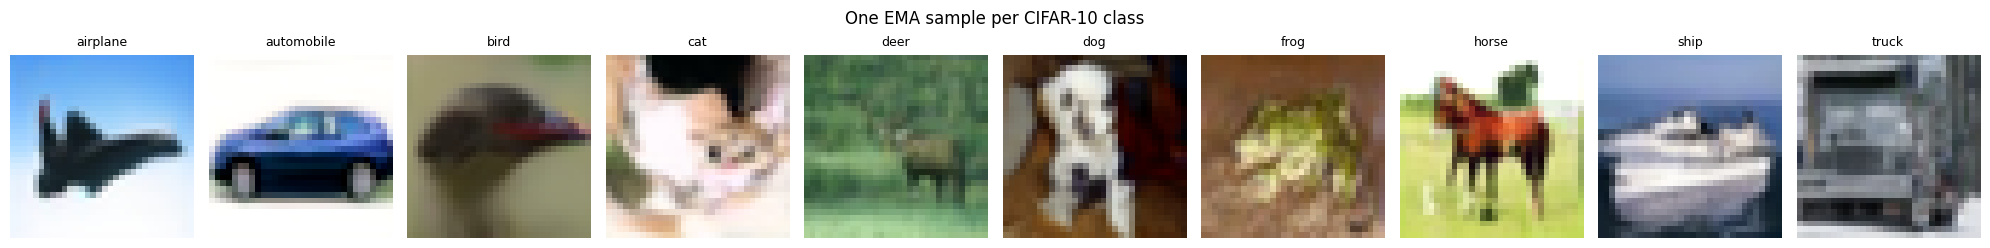

In [13]:
import math
import matplotlib.pyplot as plt

# -------------------------
# Model (matches your checkpoint keys)
# -------------------------
class TimeEmbedding(nn.Module):
    """
    Sinusoidal timestep embedding -> small MLP.
    Produces a vector of size time_dim.
    """
    def __init__(self, dim=128, hidden_mult=4):
        super().__init__()
        self.dim = dim
        hidden = dim * hidden_mult
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # t: [B] float in [0, 1]
        half_dim = self.dim // 2
        freqs = torch.exp(
            torch.arange(half_dim, device=t.device, dtype=t.dtype)
            * -(torch.log(torch.tensor(10000.0, device=t.device, dtype=t.dtype)) / half_dim)
        )
        args = t[:, None] * freqs[None, :]  # [B, half_dim]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # [B, dim] if dim even
        if emb.shape[1] != self.dim:
            # if dim is odd, pad
            emb = F.pad(emb, (0, self.dim - emb.shape[1]))
        return self.mlp(emb)

class ResBlockFiLM(nn.Module):
    """
    ResBlock with FiLM conditioning from an embedding vector (time+label).
    Conditioning is applied as scale+shift after GroupNorm:
        h = GN(h) * (1 + scale) + shift
    """
    def __init__(self, in_ch, out_ch, emb_dim, groups=32, dropout=0.0):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch

        self.norm1 = nn.GroupNorm(groups, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        # project embedding -> (scale, shift)
        self.emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, 2 * out_ch),
        )

        self.skip = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x, emb):
        # x: [B,C,H,W], emb: [B, emb_dim]
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        h = self.norm2(h)
        scale_shift = self.emb_proj(emb)  # [B, 2*out_ch]
        scale, shift = torch.chunk(scale_shift, 2, dim=1)
        scale = scale[:, :, None, None]
        shift = shift[:, :, None, None]
        h = h * (1.0 + scale) + shift

        h = F.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        return h + self.skip(x)

class SelfAttention2d(nn.Module):
    def __init__(self, channels, num_heads=4, gn_groups=32):
        super().__init__()
        assert channels % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.scale = self.head_dim ** -0.5

        self.norm = nn.GroupNorm(gn_groups, channels)
        self.qkv = nn.Conv2d(channels, 3 * channels, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)  # [B,3C,H,W]
        q, k, v = qkv.chunk(3, dim=1)

        N = H * W
        q = q.view(B, self.num_heads, self.head_dim, N).permute(0, 1, 3, 2)  # [B,h,N,d]
        k = k.view(B, self.num_heads, self.head_dim, N)                      # [B,h,d,N]
        v = v.view(B, self.num_heads, self.head_dim, N).permute(0, 1, 3, 2)  # [B,h,N,d]

        attn = (q @ k) * self.scale
        attn = attn.softmax(dim=-1)

        out = attn @ v
        out = out.permute(0, 1, 3, 2).contiguous().view(B, C, H, W)
        out = self.proj(out)
        return x + out

class UNetCIFAR3Level_Attn_CFG(nn.Module):
    """
    ε-prediction U-Net with attention at 32x32, 16x16, 8x8 and 4x4,
    plus classifier-free guidance conditioning via null label = num_classes.
    """
    def __init__(
        self,
        time_dim=32,
        base_channels=128,
        img_channels=3,
        num_classes=10,
        attn_heads=4,
        dropout=0.0,
        gn_groups=32,
    ):
        super().__init__()
        self.time_dim = time_dim
        self.num_classes = num_classes
        self.null_label = num_classes

        self.time_mlp = TimeEmbedding(dim=time_dim)
        self.label_emb = nn.Embedding(num_classes + 1, time_dim)

        C = base_channels
        emb_dim = time_dim

        # Stem
        self.in_conv = nn.Conv2d(img_channels, C, 3, padding=1)

        # Encoder
        self.down1 = ResBlockFiLM(C, C, emb_dim, groups=gn_groups, dropout=dropout)
        self.attn32 = SelfAttention2d(C, num_heads=attn_heads, gn_groups=gn_groups)
        self.pool1 = nn.MaxPool2d(2)  # 32 -> 16

        self.down2 = ResBlockFiLM(C, 2 * C, emb_dim, groups=gn_groups, dropout=dropout)
        self.attn16 = SelfAttention2d(2 * C, num_heads=attn_heads, gn_groups=gn_groups)
        self.pool2 = nn.MaxPool2d(2)  # 16 -> 8

        self.down3 = ResBlockFiLM(2 * C, 4 * C, emb_dim, groups=gn_groups, dropout=dropout)
        self.attn8 = SelfAttention2d(4 * C, num_heads=attn_heads, gn_groups=gn_groups)
        self.pool3 = nn.MaxPool2d(2)  # 8 -> 4

        # Bottleneck
        self.bottleneck = ResBlockFiLM(4 * C, 8 * C, emb_dim, groups=gn_groups, dropout=dropout)
        self.attn4 = SelfAttention2d(8 * C, num_heads=attn_heads, gn_groups=gn_groups)

        # Decoder
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(8 * C, 4 * C, 3, padding=1),
        )
        self.dec3 = ResBlockFiLM(8 * C, 4 * C, emb_dim, groups=gn_groups, dropout=dropout)
        self.dec3_attn = SelfAttention2d(4 * C, num_heads=attn_heads, gn_groups=gn_groups)

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(4 * C, 2 * C, 3, padding=1),
        )
        self.dec2 = ResBlockFiLM(4 * C, 2 * C, emb_dim, groups=gn_groups, dropout=dropout)
        self.dec2_attn16 = SelfAttention2d(2 * C, num_heads=attn_heads, gn_groups=gn_groups)

        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(2 * C, C, 3, padding=1),
        )
        self.dec1 = ResBlockFiLM(2 * C, C, emb_dim, groups=gn_groups, dropout=dropout)
        self.dec1_attn32 = SelfAttention2d(C, num_heads=attn_heads, gn_groups=gn_groups)

        self.out_norm = nn.GroupNorm(gn_groups, C)
        self.out_conv = nn.Conv2d(C, img_channels, 3, padding=1)

    def forward(self, x, t, y=None):
        B = x.shape[0]
        temb = self.time_mlp(t)

        if y is None:
            y = torch.full((B,), self.null_label, device=x.device, dtype=torch.long)
        yemb = self.label_emb(y)

        emb = temb + yemb

        h0 = self.in_conv(x)

        d1 = self.down1(h0, emb)
        d1 = self.attn32(d1)
        p1 = self.pool1(d1)

        d2 = self.down2(p1, emb)
        d2 = self.attn16(d2)
        p2 = self.pool2(d2)

        d3 = self.down3(p2, emb)
        d3 = self.attn8(d3)
        p3 = self.pool3(d3)

        b = self.bottleneck(p3, emb)
        b = self.attn4(b)

        u3 = self.up3(b)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.dec3(u3, emb)
        u3 = self.dec3_attn(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.dec2(u2, emb)
        u2 = self.dec2_attn16(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.dec1(u1, emb)
        u1 = self.dec1_attn32(u1)

        out = self.out_norm(u1)
        out = F.silu(out)
        out = self.out_conv(out)
        return out


# -------------------------
# VPSDE + sampler
# -------------------------
class VPSDE:
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0):
        self.beta_min = float(beta_min)
        self.beta_max = float(beta_max)
        self.T = float(T)

    def beta(self, t: torch.Tensor) -> torch.Tensor:
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def int_beta(self, t: torch.Tensor) -> torch.Tensor:
        return self.beta_min * t + 0.5 * (self.beta_max - self.beta_min) * t**2

    def alpha(self, t: torch.Tensor) -> torch.Tensor:
        return torch.exp(-0.5 * self.int_beta(t))

    def sigma(self, t: torch.Tensor) -> torch.Tensor:
        a = self.alpha(t)
        return torch.sqrt((1.0 - a * a).clamp(min=1e-12))

    def drift(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        b = self.beta(t).view(-1, 1, 1, 1)
        return -0.5 * b * x

@torch.no_grad()
def sample_prob_flow_heun_eps_cfg(
    model: nn.Module,
    sde: VPSDE,
    y: torch.Tensor,                 # [B] labels 0..9
    guidance_w: float = 4.0,
    num_steps: int = 200,
    t_min: float = 1e-4,
    img_size: int = 32,
    img_channels: int = 3,
    clamp_x: bool = True,
    clamp_val: float = 2.0,
    time_power: float = 2.0,
    device: str = "cuda",
):
    """
    Probability-flow ODE with Heun integration using eps-prediction + CFG.

    score(x,t) = -eps(x,t) / sigma(t)
    dx/dt = f(x,t) - 0.5 * g(t)^2 * score(x,t)
         = drift(x,t) - 0.5*beta(t) * (-eps/sigma)
    """
    model.eval()
    B = y.shape[0]
    y = y.to(device).long()

    # time grid: more steps near small t
    u = torch.linspace(0.0, 1.0, num_steps, device=device)
    t_grid = t_min + (1.0 - t_min) * (u ** time_power)
    t_grid = torch.flip(t_grid, dims=[0])  # 1 -> t_min

    x = torch.randn(B, img_channels, img_size, img_size, device=device)

    def ode_drift(x: torch.Tensor, t_scalar: float) -> torch.Tensor:
        t = torch.full((B,), float(t_scalar), device=device, dtype=x.dtype)

        beta  = sde.beta(t).view(B, 1, 1, 1)
        sigma = sde.sigma(t).view(B, 1, 1, 1).clamp_min(1e-12)

        # unconditional (null label) via y=None
        eps_u = model(x, t, y=None)
        eps_c = model(x, t, y=y)

        eps = eps_u + guidance_w * (eps_c - eps_u)

        drift = sde.drift(x, t) - 0.5 * beta * (-eps / sigma)
        return drift

    for i in range(len(t_grid) - 1):
        t0 = t_grid[i].item()
        t1 = t_grid[i + 1].item()
        dt = t1 - t0  # negative

        k1 = ode_drift(x, t0)
        x_pred = x + dt * k1
        k2 = ode_drift(x_pred, t1)

        x = x + 0.5 * dt * (k1 + k2)

        if clamp_x:
            x = x.clamp(-clamp_val, clamp_val)

    return x

@torch.no_grad()
def sample_one_per_class(model, sde, guidance_w=4.0, num_steps=200, t_min=1e-4, device="cuda"):
    labels = torch.arange(10, device=device)
    x = sample_prob_flow_heun_eps_cfg(
        model=model,
        sde=sde,
        y=labels,
        guidance_w=guidance_w,
        num_steps=num_steps,
        t_min=t_min,
        device=device,
    )
    return x, labels

CIFAR10_NAMES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def to_01(x):
    """Map from [-1,1] → [0,1]."""
    return (x.clamp(-1, 1) + 1) * 0.5

def show_class_row(samples, labels=None, title="One sample per class"):
    """
    samples: [B,3,32,32] in [-1,1]
    labels:  [B] optional
    """
    x = to_01(samples.detach().cpu())
    B = x.size(0)

    plt.figure(figsize=(2 * B, 2.5))
    for i in range(B):
        plt.subplot(1, B, i + 1)
        img = x[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis("off")
        if labels is not None:
            lbl = int(labels[i])
            plt.title(CIFAR10_NAMES[lbl], fontsize=9)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def show_grid(samples, nrow=4, title="Samples"):
    x = to_01(samples.detach().cpu())
    B = x.size(0)
    ncol = math.ceil(B / nrow)

    plt.figure(figsize=(2 * ncol, 2 * nrow))
    for i in range(B):
        plt.subplot(nrow, ncol, i + 1)
        img = x[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- match training hyperparams ---
    num_classes = 10
    time_dim = 32
    base_channels = 128
    img_channels = 3
    attn_heads = 4
    beta_min = 0.1
    beta_max = 20.0
    T = 1.0

    ema_weights_path = "ema_weights_final_model.pth"

    # Build model + load EMA weights
    ema_model = UNetCIFAR3Level_Attn_CFG(
        time_dim=time_dim,
        base_channels=base_channels,
        img_channels=img_channels,
        num_classes=num_classes,
        attn_heads=attn_heads,
    ).to(device)

    ema_sd = torch.load(ema_weights_path, map_location=device)
    ema_model.load_state_dict(ema_sd, strict=True)
    ema_model.eval()

    # Build SDE
    sde = VPSDE(beta_min=beta_min, beta_max=beta_max, T=T)

    # Sample
    samples, labels = sample_one_per_class(
        ema_model, sde,
        guidance_w=4.0,
        num_steps=500,
        t_min=1e-4,
        device=device
    )

    # Visualize (assumes model outputs are roughly in [-1, 1])
    show_class_row(
        samples,
        labels=labels,
        title="One EMA sample per CIFAR-10 class"
    )



if __name__ == "__main__":
    main()
